In [1]:
# Import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cmaps

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as feature
from cartopy.util import add_cyclic_point

# Import plotting functions
# import res_vs as rv

In [2]:
# File paths and names
file_dir = "/scratch/racosta6/resolution-test/"
file1_name = "F.1850x2.0_C5_280_ihesp1046.01_ANN_concat.nc"
file2_name = "F.1850x1.0_C5_280_ihesp1046.01_ANN_concat.nc"
file3_name = "F.1850x0.25_C5_280_ihesp1046.01_ANN_concat.nc"

# Load in datasets
ds1 = xr.open_dataset(file_dir + file1_name)
ds2 = xr.open_dataset(file_dir + file2_name)
ds3 = xr.open_dataset(file_dir + file3_name)

In [3]:
ds1

<xarray.Dataset>
Dimensions:        (time: 12, lat: 96, lon: 144, lev: 30, ilev: 31, slat: 95, slon: 144, nbnd: 2)
Coordinates:
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat           (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon           (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
  * time           (time) object 0010-08-02 12:00:00 ... 0011-07-02 12:00:00
Dimensions without coordinates: nbnd
Data variables: (12/167)
    AEROD_v        (time, lat, lon) float32 ...
    ANRAIN         (time, lev, lat, lon) float32 ...
    ANSNOW         (time, lev, lat, lon) float32 ...
    AODDUST1       (time, lat, lon) float32 ...
    AODDUST3       (time, lat, lon) float32 ...
    AODVIS         (time, lat, lon) float32 ...
    ...             ...
    soa_a2_SRF     (time, lat, lon) float32 ...
    sol_tsi        (time) float64 ...
    time_bnds      (time, nbnd) object ...
    time_written   (time) |S8 ...
    w_stag         (slat) float64 ...
    wnummax        (lat) int32 ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             F.1850x2.0_C5_280_ihesp1046.01
    title:            UNSET
    logname:          pacosta
    host:             derecho3
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/derecho/scratch/pacosta/F.1850x2.0_C5_280_ihesp1...
    topography_file:  /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/co...
    history:          Sun Jul  7 06:50:49 2024: ncrcat -O F.1850x2.0_C5_280_i...
    NCO:              netCDF Operators version 5.1.9 (Homepage = http://nco.s...

In [4]:
def data_filter_djf(vr_arr, start_lat, end_lat, start_lon, end_lon):

    # Return arr
    vr_djf_arr = []

    # Loop through the datasets and filter
    for i in range(len(vr_arr)):
        
        # Extract the specific dataset
        vr = vr_arr[i]    

        # Find the nearest index for the given latitude and longitude
        near_start_lat = vr.sel(lat=start_lat, method='nearest').lat
        near_end_lat = vr.sel(lat=end_lat, method='nearest').lat

        near_start_lon = vr.sel(lon=start_lon, method='nearest').lon
        near_end_lon = vr.sel(lon=end_lon, method='nearest').lon

        # Get the index of the nearest latitudes
        start_lat_index = vr.lat.values.tolist().index(near_start_lat)
        end_lat_index = vr.lat.values.tolist().index(near_end_lat)

        # Get the index of the nearest longitudes
        start_lon_index = vr.lon.values.tolist().index(near_start_lon)
        end_lon_index = vr.lon.values.tolist().index(near_end_lon)

        vr_jf = vr[0:2, start_lat_index:end_lat_index, start_lon_index:end_lon_index]
        vr_d = vr[11, start_lat_index:end_lat_index, start_lon_index:end_lon_index]

        vr_djf = xr.concat([vr_jf, vr_d], dim='time')
        
        vr_djf = vr_djf.mean(dim='time')

        vr_djf_arr.append(vr_djf)

    return vr_djf_arr

In [5]:
# Function to streamline plotting
def plot_res_comparison(ds_arr, cmap, cbar_title, start, end, titles, path, save, extent=[-180, 180, -90, 90], lon_step=60, lat_step=30, step=0.5):

    # Adjust the font size for poster
    # plt.rcParams.update({'font.size': 14})  
    
    # Define the figure and each axis for the 1 rows and 3 columns
    fig, axs = plt.subplots(nrows=1, ncols=3,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(16, 5.5))

    # Loop over all of the datasets and plot
    for i in range(len(ds_arr)):

        # Select the dataset
        data = ds_arr[i]

        # Add the cyclic point
        data, lons = add_cyclic_point(data, coord=data['lon'])

        # Adjust the coloring so that the color gradient is finer
        steps = np.arange(start, end, step)

        # Contour plot
        cs = axs[i].contourf(lons, ds_arr[i].lat, data, levels=steps,
                            transform=ccrs.PlateCarree(),
                            cmap=cmap, extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(titles[i])

        axs[i].set_extent(extent, crs=ccrs.PlateCarree())

        # Draw the coastines for each subplot
        axs[i].coastlines()

        # Define the xticks for longitude
        axs[i].set_xticks(np.arange(extent[0], extent[1] + 1, lon_step), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[i].set_yticks(np.arange(extent[2], extent[3] + 1, lat_step), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Add a colorbar and title it
        cbar = plt.colorbar(cs, ax=axs[i], orientation='horizontal')
        cbar.set_label(cbar_title)
        cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))

    # Save the figure, or don't, show figure either way
    if save == True:
        plt.savefig(fname=path, format='pdf')
        plt.show()
    else:
        plt.show()

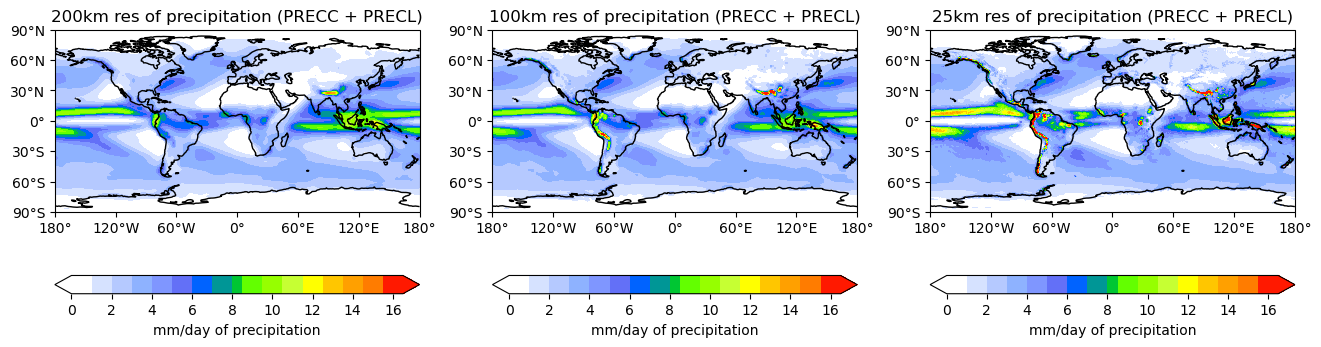

In [6]:
# Average the data and set it to a variable
prect1_ann = ds1.PRECC.mean(dim='time') + ds1.PRECL.mean(dim='time')
prect2_ann = ds2.PRECC.mean(dim='time') + ds2.PRECL.mean(dim='time')
prect3_ann = ds3.PRECC.mean(dim='time') + ds3.PRECL.mean(dim='time')

# Convert to mm/day
prect1_ann = prect1_ann*1000*60*60*24
prect2_ann = prect2_ann*1000*60*60*24
prect3_ann = prect3_ann*1000*60*60*24

# For looping through the data
prect_arr = [prect1_ann, prect2_ann, prect3_ann]

# Titles for each subplot
titles = ['200km res of precipitation (PRECC + PRECL)', '100km res of precipitation (PRECC + PRECL)', '25km res of precipitation (PRECC + PRECL)']

# Color map for precipitation
precipcmap = cmaps.precip3_16lev

# Colorbar title
cbar_title = 'mm/day of precipitation'

# Range of values
start = 0
end = 17

# Path to save the figure
path = '/home/vreddy6/code/project/output_plots/precip_all_res.pdf'

# Plot the data
plot_res_comparison(prect_arr, precipcmap, cbar_title, start, end, titles, path, True)

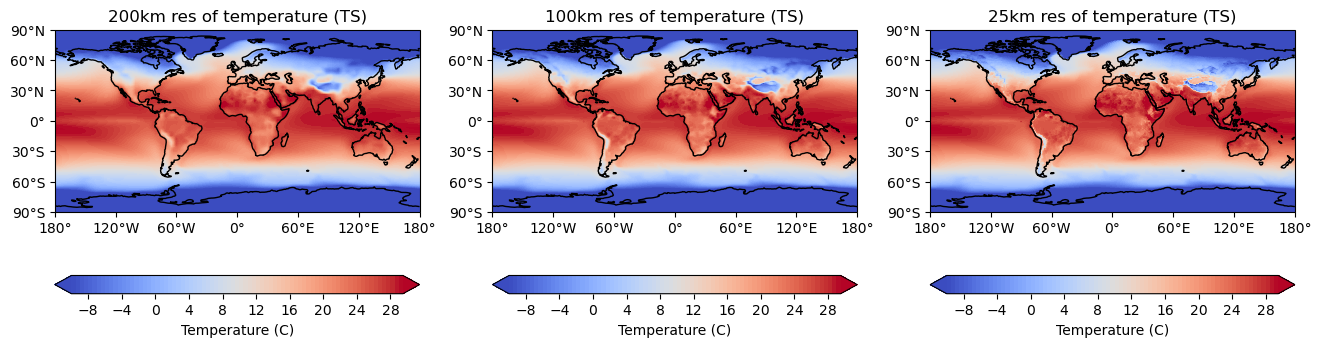

In [7]:
# Average over time and assign data to variables
ts1_ann = ds1.TS.mean(dim='time')
ts2_ann = ds2.TS.mean(dim='time')
ts3_ann = ds3.TS.mean(dim='time')

# Convert to Celsius
ts1_ann = ts1_ann - 273.15
ts2_ann = ts2_ann - 273.15
ts3_ann = ts3_ann - 273.15

# Array for loop plotting
ts_arr = [ts1_ann, ts2_ann, ts3_ann]

# Titles for loop plotting
titles = ['200km res of temperature (TS)', '100km res of temperature (TS)', '25km res of temperature (TS)']

# Plot the data
plot_res_comparison(ts_arr, 'coolwarm', 'Temperature (C)', -10, 30, titles, '/home/vreddy6/code/project/output_plots/temp_all_res.pdf', True)


/home/vreddy6/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/vreddy6/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/vreddy6/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/vreddy6/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated

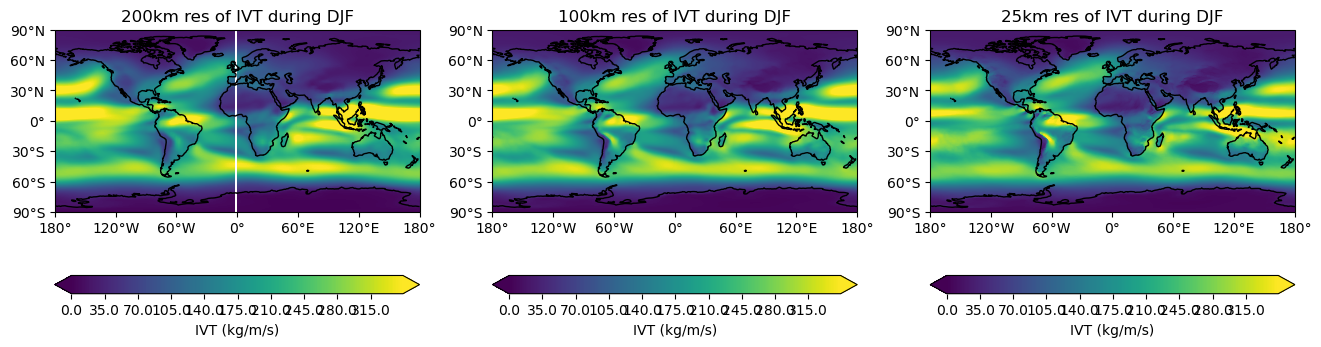

In [6]:
ivt200 = ds1.IVT
ivt100 = ds2.IVT
ivt25 = ds3.IVT

vr_arr = [ivt200, ivt100, ivt25]

ivt_1, ivt_2, ivt_3 = data_filter_djf(vr_arr, -90, 90, 0, 360)

# Array for loop plotting
ivt_arr = [ivt_1, ivt_2, ivt_3]

# Titles for loop plotting
titles = ['200km res of IVT during DJF', '100km res of IVT during DJF', '25km res of IVT during DJF']

#  [-160, -100, 20, 60], 20, 10,

# Plot the data
plot_res_comparison(ivt_arr, 'viridis', 'IVT (kg/m/s)', 0, 350, titles, '/home/vreddy6/code/project/output_plots/ivt_all_res.pdf', True, step=1)

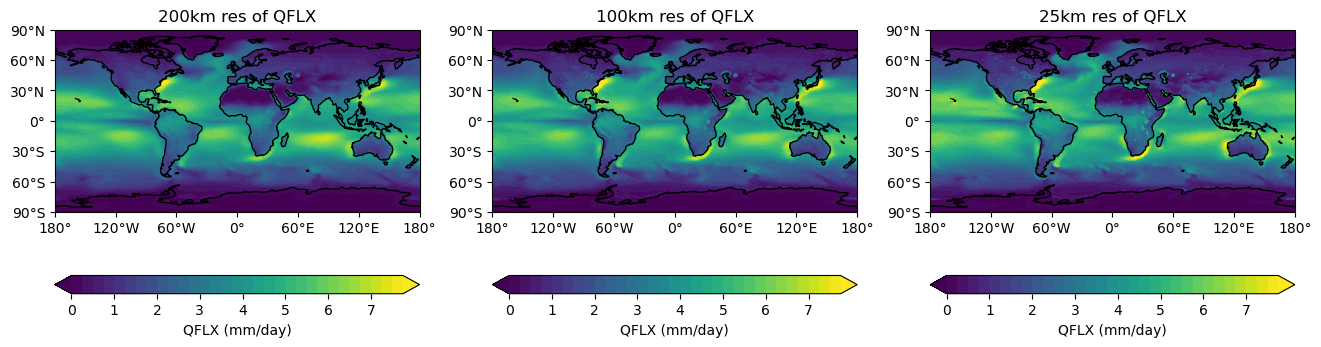

In [9]:
# Average over time and assign data to variables
qflx1_ann = ds1.QFLX.mean(dim='time')
qflx2_ann = ds2.QFLX.mean(dim='time')
qflx3_ann = ds3.QFLX.mean(dim='time')

# Convert kg/m^2/s to mm/day
qflx1_ann = qflx1_ann*86400
qflx2_ann = qflx2_ann*86400
qflx3_ann = qflx3_ann*86400

# Array for loop plotting
qflx_arr = [qflx1_ann, qflx2_ann, qflx3_ann]

# Titles for loop plotting
titles = ['200km res of QFLX', '100km res of QFLX', '25km res of QFLX']

# Plot the data
plot_res_comparison(qflx_arr, 'viridis', 'QFLX (mm/day)', 0, 8, titles, '/home/vreddy6/code/project/output_plots/qflx_all_res.pdf', True, step=0.25)

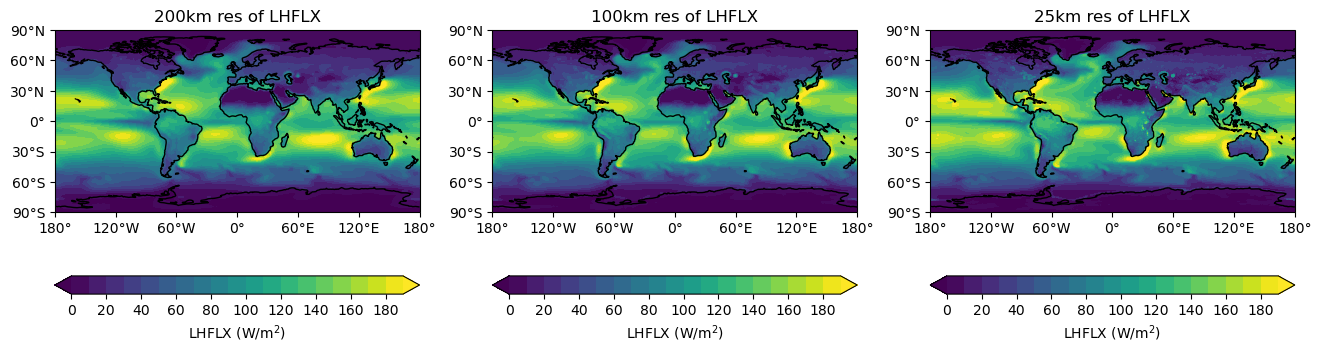

In [10]:
# Average over time and assign data to variables
lhflx1_ann = ds1.LHFLX.mean(dim='time')
lhflx2_ann = ds2.LHFLX.mean(dim='time')
lhflx3_ann = ds3.LHFLX.mean(dim='time')

# Arrays for loop plotting
lhflx_arr = [lhflx1_ann, lhflx2_ann, lhflx3_ann]

# Titles for loop plotting
titles = ['200km res of LHFLX', '100km res of LHFLX', '25km res of LHFLX']

# Plot the data
plot_res_comparison(lhflx_arr, 'viridis', r'LHFLX (W/m$^2$)', 0, 200, titles, '/home/vreddy6/code/project/output_plots/lhflx_all_res.pdf', True, step=10)

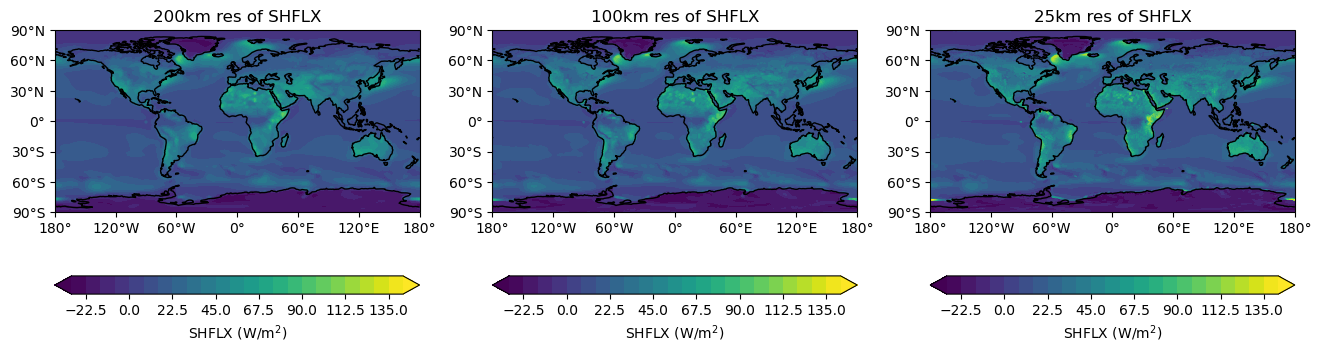

In [11]:
# Average over time and assign data to variables
shflx1_ann = ds1.SHFLX.mean(dim='time')
shflx2_ann = ds2.SHFLX.mean(dim='time')
shflx3_ann = ds3.SHFLX.mean(dim='time')

# Arrays for loop plotting
shflx_arr = [shflx1_ann, shflx2_ann, shflx3_ann]

# Titles for loop plotting
titles = ['200km res of SHFLX', '100km res of SHFLX', '25km res of SHFLX']

# Plot the data
plot_res_comparison(shflx_arr, 'viridis', r'SHFLX (W/m$^2$)', -30, 150, titles, '/home/vreddy6/code/project/output_plots/shflx_all_res.pdf', True, step=7.5)

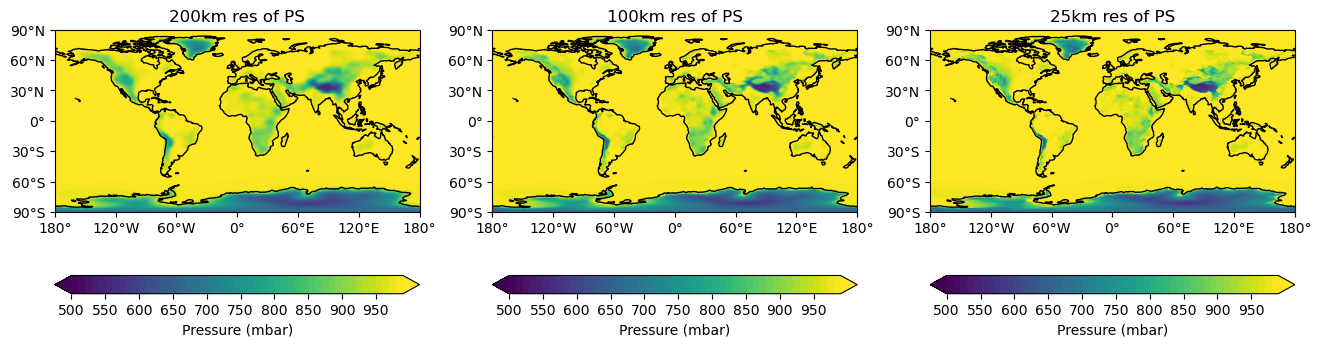

In [12]:
# Average over time and assign data to variables
ps1_ann = ds1.PS.mean(dim='time')
ps2_ann = ds2.PS.mean(dim='time')
ps3_ann = ds3.PS.mean(dim='time')

# Convert to mbar
ps1_ann = ps1_ann/100
ps2_ann = ps2_ann/100
ps3_ann = ps3_ann/100

# Arrays for loop plotting
ps_arr = [ps1_ann, ps2_ann, ps3_ann]

# Titles for loop plotting
titles = ['200km res of PS', '100km res of PS', '25km res of PS']

# Plot the data
plot_res_comparison(ps_arr, 'viridis', 'Pressure (mbar)', 500, 1000, titles, '/home/vreddy6/code/project/output_plots/ps_all_res.pdf', True, step=10)

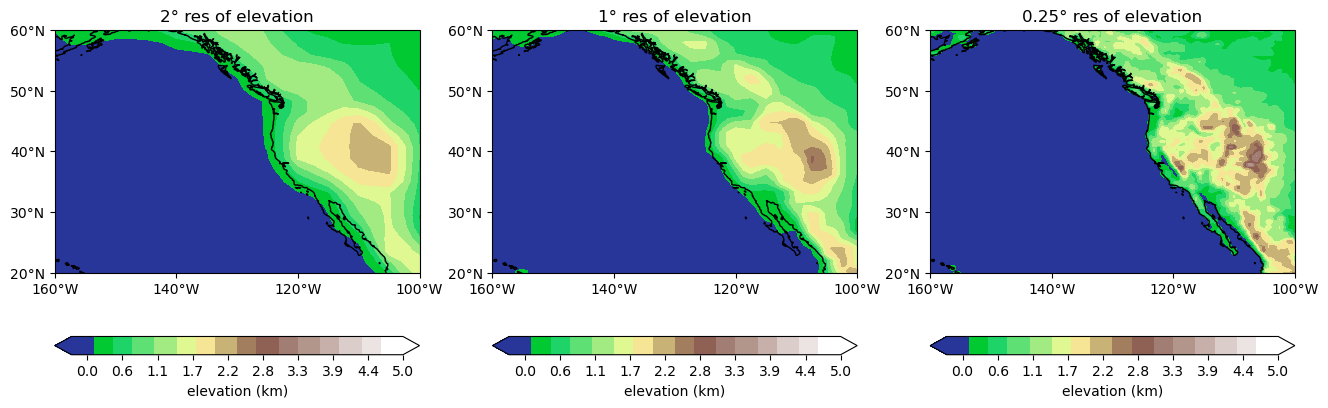

In [8]:
# Average over time and assign data to variables
phis1_ann = ds1.PHIS.mean(dim='time')
phis2_ann = ds2.PHIS.mean(dim='time')
phis3_ann = ds3.PHIS.mean(dim='time')

# Convert from m^2/s^2 to km
phis1_ann = (phis1_ann/9.81)/1000
phis2_ann = (phis2_ann/9.81)/1000
phis3_ann = (phis3_ann/9.81)/1000

# Arrays for loop processing
phis_arr = [phis1_ann, phis2_ann, phis3_ann]

# Titles for loop plotting
titles = ['2° res of elevation', '1° res of elevation', '0.25° res of elevation']

# Plot the data
plot_res_comparison(phis_arr, cmaps.topo_15lev, 'elevation (km)', -0.23, 5, titles, '/home/vreddy6/code/project/output_plots/phis_all_res.pdf', True, [-160, -100, 20, 60], 20, 10, step=0.05)